In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib

In [2]:
# Function to load TIFF files from a directory
def load_tif_files(directory):
    return [rasterio.open(os.path.join(directory, f)).read() for f in os.listdir(directory) if f.endswith('.tif')]

# Function to extract features from the first two bands (VV, VH)
def extract_features(image_data):
    return np.vstack([image_data[0].flatten(), image_data[1].flatten()]).T

# Uncomment the function to include Band 3 features
# def extract_features(image_data):
#     band1, band2, band3 = image_data[0], image_data[1], image_data[2]
#     
#     # Calculate the mean of the incidence angle (band3)
#     band3_mean = np.nanmean(band3)
#     
#     # Flatten the bands
#     band1_flat = band1.flatten()
#     band2_flat = band2.flatten()
#     
#     # Calculate the ratio features
#     band1_ratio = band1_flat / band3_mean
#     band2_ratio = band2_flat / band3_mean
#     
#     # Stack the features together
#     features = np.vstack([band1_flat, band2_flat, band1_ratio, band2_ratio]).T
#     
#     return features

# Function to preprocess the data by extracting features and combining classes
def preprocess_data(non_forest_data, forest_data):
    non_forest_features = np.vstack([extract_features(bands) for bands in non_forest_data])
    forest_features = np.vstack([extract_features(bands) for bands in forest_data])
    X = np.vstack([non_forest_features, forest_features])
    y = np.hstack([np.zeros(non_forest_features.shape[0]), np.ones(forest_features.shape[0])])
    return X, y

# Function to downsample data to balance the classes (forest and non-forest)
def downsample_data(X, y, target_class_size=20000):
    np.random.seed(42)  # Ensure reproducibility
    non_forest_features = X[y == 0][~np.isnan(X[y == 0]).any(axis=1)]  # Filter out NaN values
    forest_features = X[y == 1][~np.isnan(X[y == 1]).any(axis=1)]
    non_forest_sampled = non_forest_features[np.random.choice(non_forest_features.shape[0], target_class_size, replace=False)]
    forest_sampled = forest_features[np.random.choice(forest_features.shape[0], target_class_size, replace=False)]
    X_downsampled = np.vstack([non_forest_sampled, forest_sampled])
    y_downsampled = np.hstack([np.zeros(target_class_size), np.ones(target_class_size)])
    return X_downsampled, y_downsampled

In [3]:
# Load non-forest and forest data
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"
non_forest_data = load_tif_files(non_forest_dir)
forest_data = load_tif_files(forest_dir)

# Extract features and downsample the data
X, y = preprocess_data(non_forest_data, forest_data)
X_downsampled, y_downsampled = downsample_data(X, y)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data for better performance of the classifiers
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [4]:
# Perform grid search for Random Forest hyperparameters
def rf_grid_search(X_train, y_train, X_val, y_val, param_grid):
    best_score, best_params, best_model = 0, {}, None
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
                    rf.fit(X_train, y_train)
                    score = f1_score(y_val, rf.predict(X_val), average='weighted')
                    if score > best_score:
                        best_score, best_params, best_model = score, rf.get_params(), rf
    return best_params, best_score, best_model

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Find the best Random Forest model based on validation performance
rf_best_params, rf_best_score, rf_best_model = rf_grid_search(X_train_norm, y_train, X_val_norm, y_val, param_grid)
print(f"Best RF Parameters: {rf_best_params}, Best F1 Score: {rf_best_score:.4f}")
rf_classifier = rf_best_model

Best RF Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}, Best F1 Score: 0.7377


In [5]:
# Perform grid search for SVM hyperparameters
def svm_grid_search(X_train, y_train, X_val, y_val, param_grid):
    best_score, best_params, best_model = 0, {}, None
    for C in param_grid['C']:
        for kernel in param_grid['kernel']:
            for gamma in param_grid['gamma']:
                svm_classifier = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)
                svm_classifier.fit(X_train, y_train)
                score = f1_score(y_val, svm_classifier.predict(X_val), average='weighted')
                if score > best_score:
                    best_score, best_params, best_model = score, svm_classifier.get_params(), svm_classifier
    print(f"Best SVM Validation F1 Score: {best_score:.4f} with parameters: {best_params}")
    return best_model

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Find the best SVM model based on validation performance
svm_best_model = svm_grid_search(X_train_norm, y_train, X_val_norm, y_val, param_grid)
svm_classifier = svm_best_model

Best SVM Validation F1 Score: 0.7398 with parameters: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


,Model,Accuracy,Precision (Non-Forest),Recall (Non-Forest),F1-Score (Non-Forest),Precision (Forest),Recall (Forest),F1-Score (Forest)
0,Random Forest,0.744667,0.783659,0.678512,0.727305,0.714707,0.811308,0.759950
1,SVM,0.748000,0.789047,0.679508,0.730193,0.716760,0.816996,0.763602


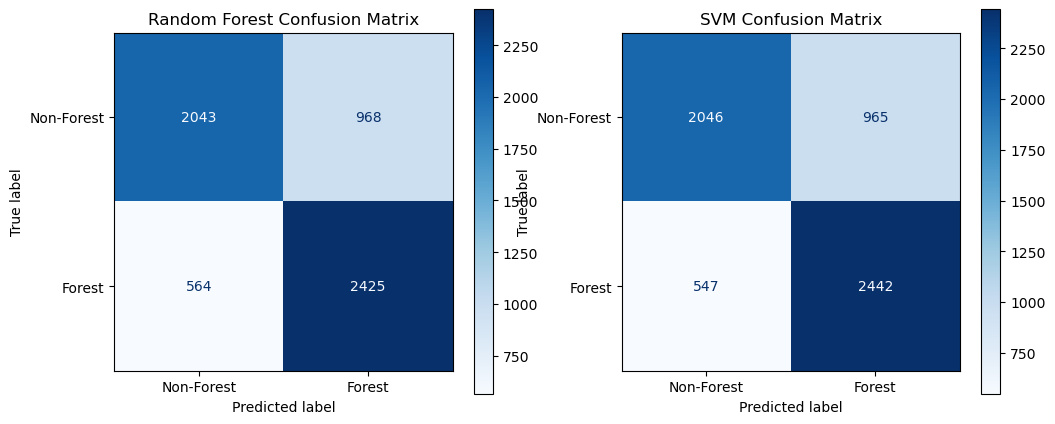

In [10]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

def compare_models(rf_classifier, svm_classifier, X_test, y_test):
    rf_test_predictions = rf_classifier.predict(X_test)
    svm_test_predictions = svm_classifier.predict(X_test)
    
    rf_test_accuracy = (rf_test_predictions == y_test).mean()
    svm_test_accuracy = (svm_test_predictions == y_test).mean()
    
    rf_classification_report = classification_report(y_test, rf_test_predictions, target_names=['Non-Forest', 'Forest'], output_dict=True)
    svm_classification_report = classification_report(y_test, svm_test_predictions, target_names=['Non-Forest', 'Forest'], output_dict=True)
    
    metrics_df = pd.DataFrame({
        'Model': ['Random Forest', 'SVM'],
        'Accuracy': [rf_test_accuracy, svm_test_accuracy],
        'Precision (Non-Forest)': [rf_classification_report['Non-Forest']['precision'], svm_classification_report['Non-Forest']['precision']],
        'Recall (Non-Forest)': [rf_classification_report['Non-Forest']['recall'], svm_classification_report['Non-Forest']['recall']],
        'F1-Score (Non-Forest)': [rf_classification_report['Non-Forest']['f1-score'], svm_classification_report['Non-Forest']['f1-score']],
        'Precision (Forest)': [rf_classification_report['Forest']['precision'], svm_classification_report['Forest']['precision']],
        'Recall (Forest)': [rf_classification_report['Forest']['recall'], svm_classification_report['Forest']['recall']],
        'F1-Score (Forest)': [rf_classification_report['Forest']['f1-score'], svm_classification_report['Forest']['f1-score']]
    })
    
    display(metrics_df)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    ConfusionMatrixDisplay.from_predictions(y_test, rf_test_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title("Random Forest Confusion Matrix")
    
    ConfusionMatrixDisplay.from_predictions(y_test, svm_test_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues, ax=axes[1])
    axes[1].set_title("SVM Confusion Matrix")
    
    plt.show()

# Compare Models
compare_models(rf_classifier, svm_classifier, X_test_norm, y_test)


In [11]:
# Save the best models and the scaler
joblib.dump(rf_classifier, r'D:\Development\RESEARCH\MarvinBlue\Results\rf_model.pkl')
joblib.dump(svm_classifier, r'D:\Development\RESEARCH\MarvinBlue\Results\svm_model.pkl')
joblib.dump(scaler, r'D:\Development\RESEARCH\MarvinBlue\Results\scaler.pkl')
print("Models and scaler saved successfully.")

Models and scaler saved successfully.
